In [1]:
import numpy as np
import pandas as pd


In [2]:
df=pd.read_csv('C:/Users/tokah/Documents/fyp-chord-identification/beethoven dataset/ABC-master/data/all_annotations.tsv',sep='\t')

In [4]:
df

,chord,altchord,measure,beat,totbeat,timesig,op,no,mov,length,global_key,local_key,pedal,numeral,form,figbass,changes,relativeroot,phraseend
0,.Eb.I,NaN,1,1.0,1.0,2/4,127,12,1,2.5,Eb,I,NaN,I,NaN,NaN,NaN,NaN,False
1,V43,NaN,2,1.5,3.5,2/4,127,12,1,1.5,Eb,I,NaN,V,NaN,43.0,NaN,NaN,False
2,I,NaN,3,1.0,5.0,2/4,127,12,1,2.5,Eb,I,NaN,I,NaN,NaN,NaN,NaN,False
3,V2,NaN,4,1.5,7.5,2/4,127,12,1,1.5,Eb,I,NaN,V,NaN,2.0,NaN,NaN,False
4,I6,NaN,5,1.0,9.0,2/4,127,12,1,1.0,Eb,I,NaN,I,NaN,6.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28090,I,NaN,171,1.0,542.5,2/2,95,11,4,4.0,false,I,NaN,I,NaN,NaN,NaN,NaN,False
28091,V7,NaN,172,1.0,546.5,2/2,95,11,4,4.0,false,I,NaN,V,NaN,7.0,NaN,NaN,False
28092,I,NaN,173,1.0,550.5,2/2,95,11,4,4.0,false,I,NaN,I,NaN,NaN,NaN,NaN,False
28093,V,NaN,174,1.0,554.5,2/2,95,11,4,4.0,false,I,NaN,V,NaN,NaN,NaN,NaN,False


In [5]:
h_states=['MinorI', 'MinorI+',
          'MinorbII', 'MinorII', 'MinorII7',
          'MinorIII',
          'MinorIV', 'MinorIV+',
          'MinorV', 'MinorV+', 'MinorV+7',
          'MinorVI', 'MinorGerVI', 'MinorFreVI', 'MinorItaVI',
          'MinorVII', 'MinorDimVII7', 'MinorDimVII',
          'MajorI',#18
          'MajorbII','MajorII','MajorII7',
          'MajorIII',
          'MajorIV',
          'MajorV','MajorV7',
          'MajorbVI','MajorGerVI','MajorFreVI','MajorItaVI','MajorVI',
          'MajorVII','MajorVII7','MajorDimVII7','MajorDimVII'
]

In [6]:
transition_matrix=np.array([np.zeros(len(h_states)) for i in range(len(h_states))])

In [7]:
#loop through rows
previous_local_key=' '
previous_chord=' '
def reset():
    global previous_key
    global previous_chord
    previous_local_key=' '
    previous_chord=' '

for index, row in df.iterrows():
    global previous_local_key
    global previous_chord
    current_key=''
    
    #global key is either major or minor
    assert(row['local_key'][-1].islower() or row['local_key'][-1].isupper())
    
    #find global key
    if row['local_key'][-1].islower(): 
        current_local_key='Minor'
    else:
        current_local_key='Major'
        
    #skip , if no chord here
    if pd.isna(row['numeral']):
        continue
        
    #get chord key
    if row['numeral'].islower():
        chord_key='Minor'
    else:
        chord_key='Major'
        
    #get numeral
    numeral=row['numeral'].upper()
    #rename augmented VI
    if numeral=='GER':
        numeral='GerVI'
    elif numeral=='FR':
        numeral='FreVI'
    elif numeral=='IT':
        numeral='ItaVI'
    # if chord not in our system : skip
    if numeral[0]=='#':
        reset()
        continue
    elif numeral[0]=='B':
        # if chord not in our system : skip
        if numeral not in ['bII','bVI']:
            reset()
            continue
        else:
            numeral='b'+numeral[1:]
            
    #is seventh?
    seventh='7' if (row['figbass']==7 and (row['numeral']=='II' or row['numeral']=='V' or row['numeral']=='VII') and not (row['numeral']=='V' and chord_key=='Minor' and current_local_key=='Minor')) else ''
    
    #is diminish?
    diminish='Dim' if (row['form']=='%' or row['form']=='o')and row['numeral']=='VII' else ''
    
    #major chord in minor key?
    if current_key=='Minor' and chord_key=='Major':
        major_chord_in_minor='+'
    else:
        major_chord_in_minor=''

    #chord name formation
    current_chord=chord_key+diminish+numeral+major_chord_in_minor+seventh

   


    #  skip same chord
    if previous_chord==current_chord or previous_chord==' ':
        pass
    else:
        #log transition
         #reset and skip invalid chord transition, print error and force stop
        assert(current_chord in h_states)
        assert(previous_chord in h_states)
        transition_matrix[h_states.index(previous_chord)][h_states.index(current_chord)]+=1
        #print(previous_chord,'->',current_chord)
        
    previous_local_key=current_local_key
    previous_chord=current_chord

In [10]:
transition_matrix=np.array([row/row.sum() if row.sum()>0 else row for row in transition_matrix])

In [19]:
import pickle
with open('C:/Users/tokah/Documents/fyp-chord-identification/data/beet_Transition', 'wb') as handle:
    pickle.dump(transition_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

<AxesSubplot:>

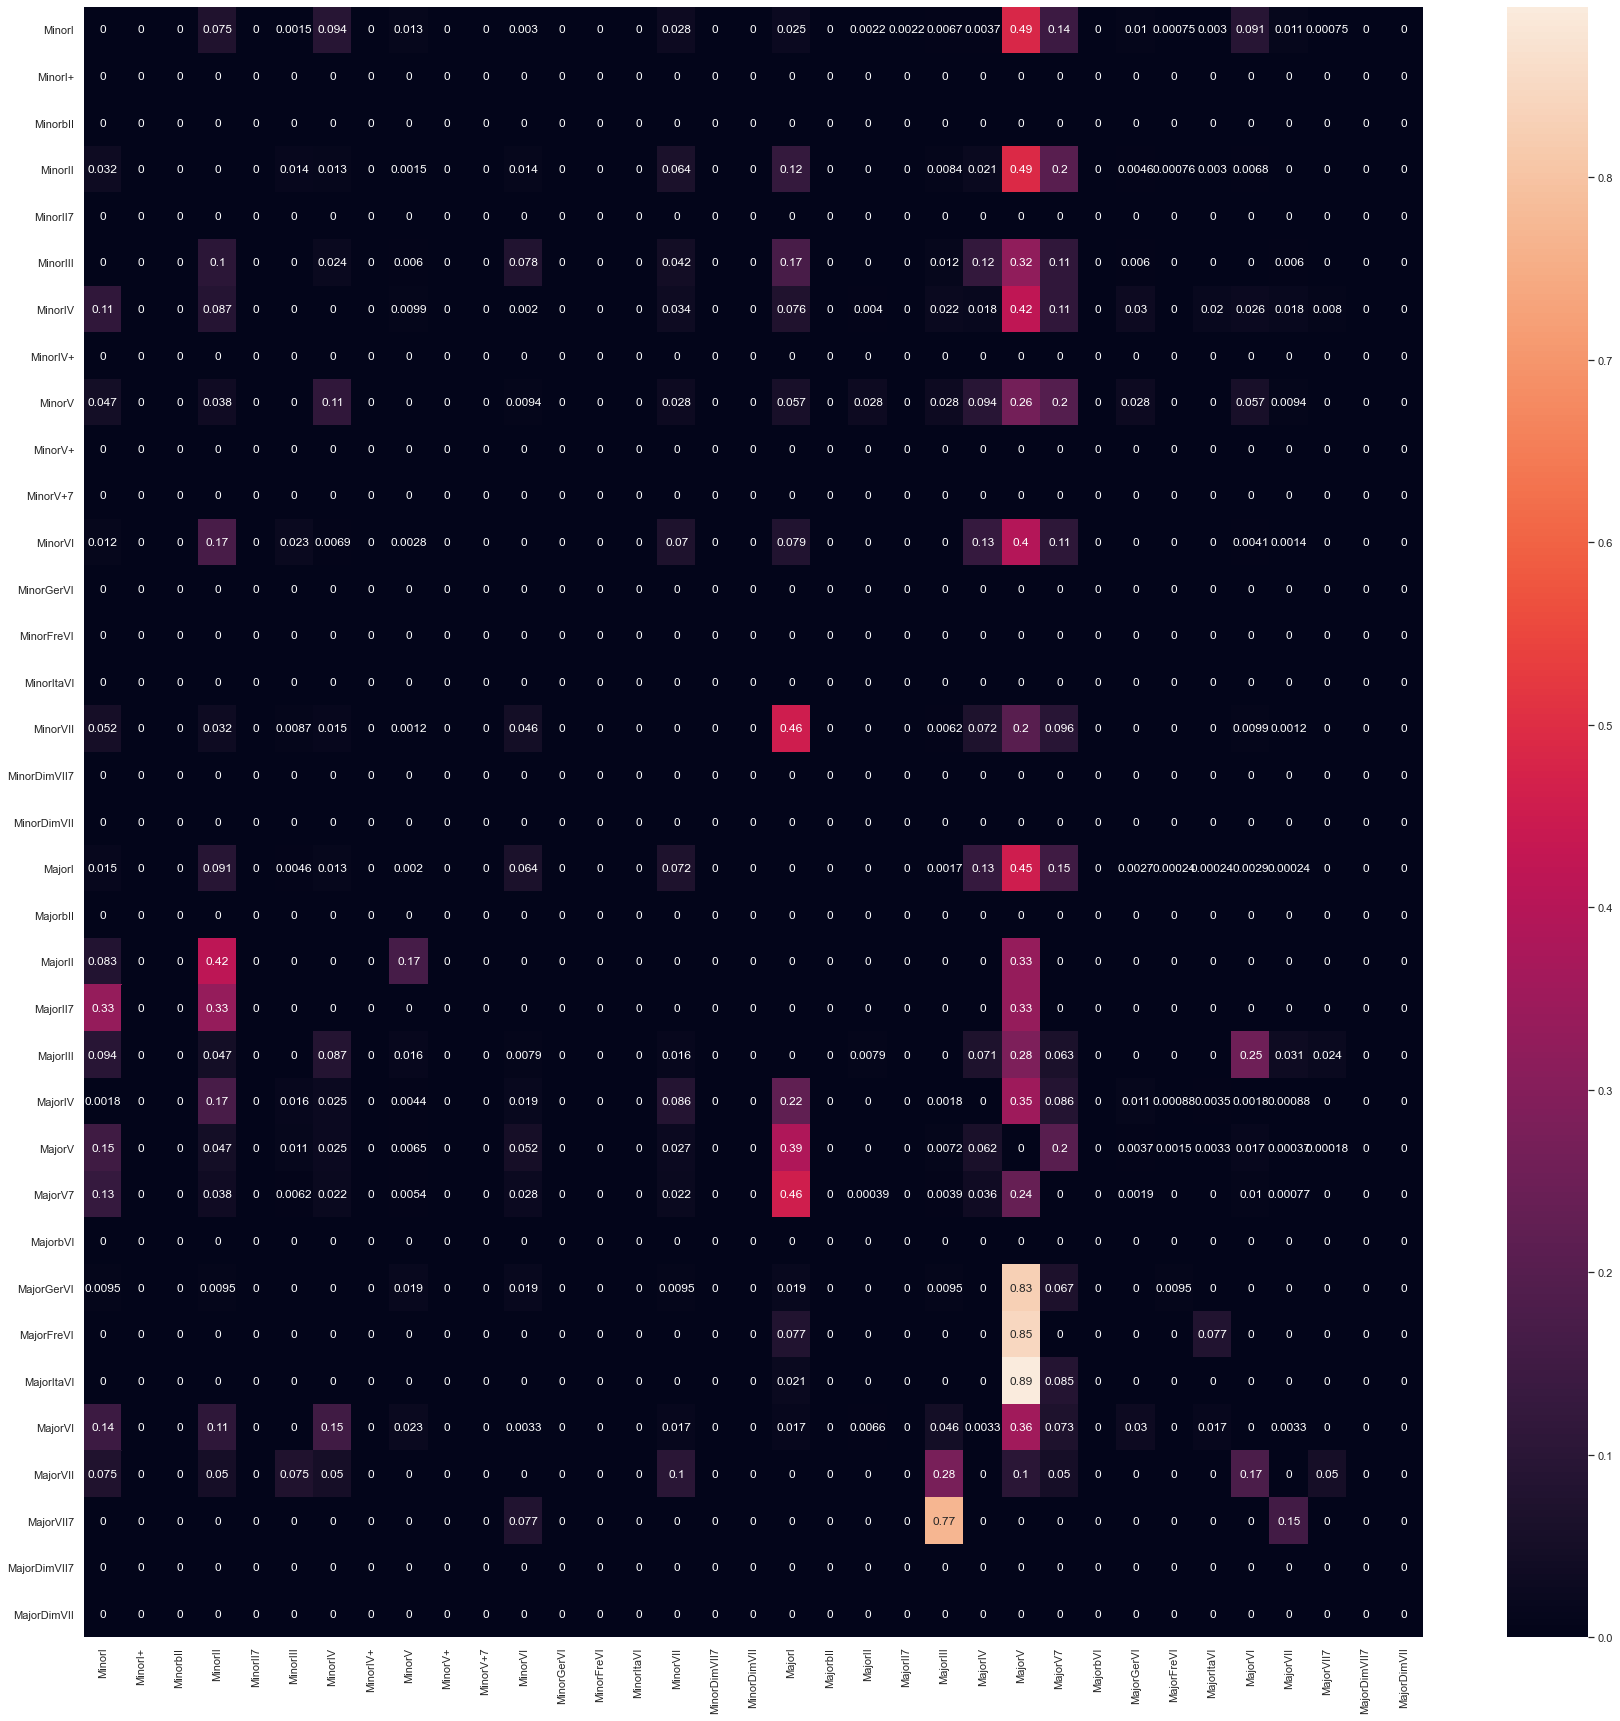

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(transition_matrix , annot=True,vmin=0,xticklabels = h_states, yticklabels = h_states )